In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal, mannwhitneyu, zscore

%matplotlib inline

## Data reading and cleaning

In [2]:
df = pd.read_csv("Data/IBS-metabolome-data.txt", sep="\t", index_col="Sample")
df.drop([np.NaN, 'BLOQ Values','ALOQ Values'], inplace=True)
df.drop(['Unnamed: 33','Unnamed: 34', 'Unnamed: 35'],
        axis=1,
        inplace=True)

In [3]:
df.columns = list(df.columns[:2]) + [" ".join(col.split(" ")[:-4]) for col in list(df.columns[2:])]

In [4]:
df.replace(to_replace="NQ",
           value=np.nan,
           inplace=True)

In [5]:
df.loc["LLOQ", "Sample Weight"] = 0
df.loc["LLOQ",:] = df.loc["LLOQ",:].astype(float)
df.loc["half LLOQ",:] = df.loc["LLOQ"]/2

In [6]:
df.iloc[2:-1,:] = df.iloc[2:-1,:].fillna(df.loc["half LLOQ",:])
df.drop("half LLOQ", inplace=True)

In [7]:
df.index = [dex.replace("Ctl","control ") for dex in df.index]
df.index = [dex.replace("  "," ") for dex in df.index]

In [8]:
df["IBS"] = [np.nan] * 3 + [dex.split(" ")[1]!="control" for dex in df.index if len(dex.split(" "))>1]

In [9]:
samples_df = df.iloc[3:,2:]
samples_df.iloc[:,:-1] = samples_df.iloc[:,:-1].astype(float)

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_58836/2785531405.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  samples_df.iloc[:,:-1] = samples_df.iloc[:,:-1].astype(float)


In [10]:
samples_df.head()

,myristic acid (14:0),myristoleic acid (14:1n5),pentadecanoic acid (15:0),palmitic acid (16:0),palmitoleic acid (16:1n7),margaric acid (17:0),stearic acid (18:0),oleic acid (18:1n9),vaccenic acid (18:1n7),linoleic acid (18:2n6),...,behenic acid (22:0),erucic acid (22:1n9),cis-13-16-docosadienoic acid (22:2n6),adrenic acid (22:4n6),osbond acid (22:5n6),docosapentaenoic acid (22:5n3),docosahexaenoic acid (22:6n3),lignoceric acid (24:0),nervonic acid (24:1n9),IBS
IBS control 1,10.40,0.480,10.90,204.0,3.04,4.61,284.0,138.0,8.84,94.2,...,12.80,0.395,0.206,0.48,5.34,0.800,1.6,12.50,1.590,False
IBS control 2,7.68,0.285,6.59,229.0,3.86,3.51,207.0,477.0,20.80,102.0,...,23.80,0.477,0.480,0.48,98.80,0.804,1.6,8.06,1.310,False
IBS control 3,8.98,0.480,7.81,579.0,5.88,6.23,383.0,1159.0,29.60,401.0,...,17.70,0.828,0.480,0.48,261.00,0.539,1.6,22.00,2.030,False
IBS control 4,1.15,0.480,0.49,36.0,2.43,1.45,36.0,63.2,2.70,48.6,...,1.42,0.183,0.480,0.48,0.48,0.800,1.6,1.48,0.246,False
IBS control 5,49.80,0.480,19.60,258.0,5.88,5.11,455.0,176.0,5.37,89.4,...,17.40,1.850,0.480,0.48,7.62,0.485,1.6,8.68,1.280,False


## Setup for volcano plot

In [11]:
ibs = samples_df[samples_df["IBS"]]
controls = samples_df[samples_df["IBS"]==False]

for col in samples_df.columns[:-1]:
    res = mannwhitneyu(ibs[col],
                       controls[col])
    samples_df.loc["pval",col] = res.pvalue
    samples_df.loc["-log10 pval", col] = -1 * np.log10(res.pvalue)
    
    samples_df.loc["fold change", col] = np.mean(ibs[col])/np.mean(controls[col])
    samples_df.loc["log2 fold change", col] = np.log2( np.mean(ibs[col]) / np.mean(controls[col]) )

In [12]:
plot_df = samples_df.T

In [13]:
plot_df.head()

,IBS control 1,IBS control 2,IBS control 3,IBS control 4,IBS control 5,IBS control 6,IBS control 7,IBS control 8,IBS control 9,IBS control 10,...,IBS N17,IBS N18,IBS N19,IBS N20,IBS N21,IBS N22,pval,-log10 pval,fold change,log2 fold change
myristic acid (14:0),10.4,7.68,8.98,1.15,49.8,1.76,8.08,11.5,4.66,5.28,...,76.7,8.78,14.9,112.0,7.37,14.2,0.169706,0.770303,1.586437,0.66579
myristoleic acid (14:1n5),0.48,0.285,0.48,0.48,0.48,0.48,0.174,0.734,0.48,0.48,...,0.716,0.48,0.167,0.453,0.48,0.48,0.587304,0.231137,0.955867,-0.065118
pentadecanoic acid (15:0),10.9,6.59,7.81,0.49,19.6,0.911,13.9,3.56,3.47,13.0,...,72.7,4.34,24.4,4.61,4.41,14.3,0.199351,0.700381,1.64382,0.717052
palmitic acid (16:0),204.0,229.0,579.0,36.0,258.0,96.3,489.0,124.0,114.0,197.0,...,1377.0,181.0,474.0,432.0,392.0,775.0,0.041303,1.384018,1.785296,0.836163
palmitoleic acid (16:1n7),3.04,3.86,5.88,2.43,5.88,14.2,2.74,3.51,2.42,2.71,...,5.29,2.57,3.09,7.43,2.95,4.89,0.908047,0.041892,1.537834,0.6209


## Make Volcano Plot

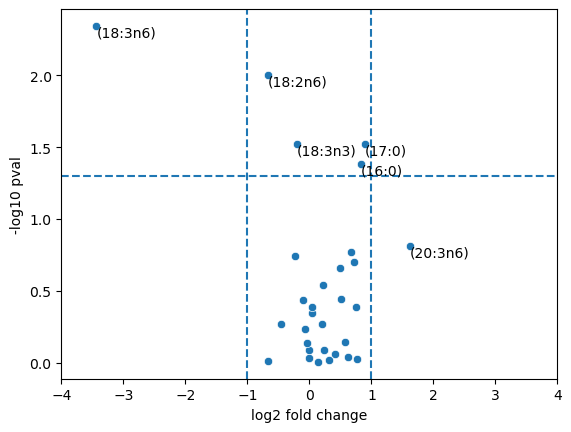

In [14]:
ax = sns.scatterplot(x="log2 fold change",
                     y="-log10 pval",
                     data=plot_df)

for name in plot_df.index:
    if plot_df.loc[name, "-log10 pval"] > -np.log10(0.05) or np.abs(plot_df.loc[name, "log2 fold change"]) > 1:
        ax.text(plot_df.loc[name, "log2 fold change"], 
                plot_df.loc[name, "-log10 pval"], 
                name.split(" ")[-1],
                horizontalalignment='left', 
                verticalalignment='top',
                size='medium',
                rotation=0)
        
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

ax.set_xlim(-4,4)

plt.savefig("Figures/Volcano-plot.pdf")
plt.show()

In [16]:
plot_df[(plot_df.loc[:,"-log10 pval"] > -np.log10(0.05)) | (np.abs(plot_df.loc[:,"log2 fold change"]) > 1)][["pval","fold change"]]

,pval,fold change
palmitic acid (16:0),0.041303,1.785296
margaric acid (17:0),0.030097,1.855316
linoleic acid (18:2n6),0.009895,0.62784
gamma-linolenic acid (18:3n6),0.004525,0.092304
alpha-linolenic acid (18:3n3),0.030087,0.870283
dihomo-gamma-linolenic acid (20:3n6),0.15428,3.064945


## Boxplots

In [31]:
altered = plot_df[plot_df.loc[:,"-log10 pval"] > -np.log10(0.05)].index

In [32]:
boxplot_df = samples_df[list(altered) + ["IBS"]].drop(["pval", "-log10 pval","fold change", "log2 fold change"])
boxplot_df = pd.melt(boxplot_df, id_vars="IBS")
boxplot_df["Lipid"] = boxplot_df["variable"].apply(lambda x: "\n(".join(x.split("(")))

ibsmapper = {True:"IBS", False:"Healthy Control"}
boxplot_df["IBS"] = boxplot_df["IBS"].apply(lambda x: ibsmapper[x])

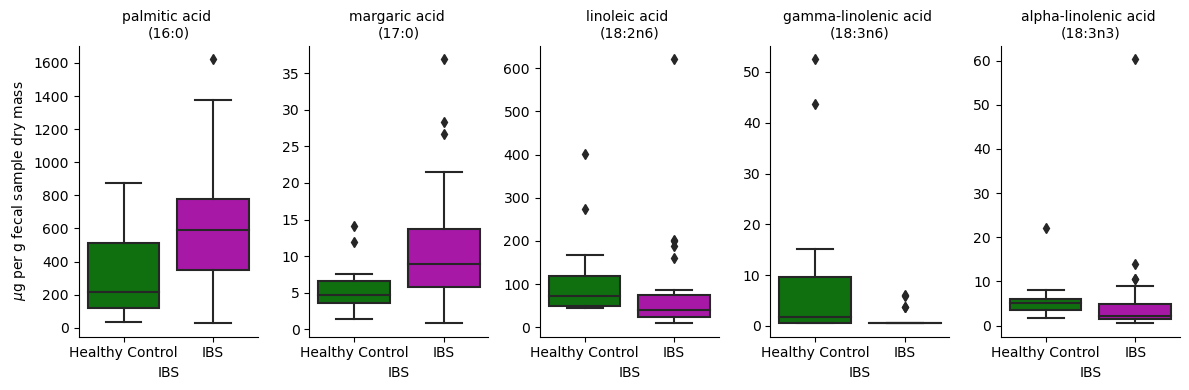

In [34]:
ax = sns.catplot(x="IBS",
                y="value",
                col="Lipid",
                data=boxplot_df,
                sharey=False,
                kind="box",palette=["g","m"])
ax.axes[0][0].set_ylabel(r"$\mu$g per g fecal sample dry mass")

for a in ax.axes[0][:5]:
    a.set_title("".join(a.get_title().split(" = ")[1:]),  fontsize="medium")

plt.gcf().set_size_inches(12,4)
plt.tight_layout()
plt.savefig("Figures/IBS_lipid_boxplots.pdf")

# Subtypes

In [177]:
metadata = pd.read_csv("Data/Final-IBS-Coding.txt", sep="\t", index_col="metabolome-ID")

In [178]:
mapper = {"mixed":"IBS-M","diarrhea":"IBS-D",}
samples_df["IBS Type"] = metadata["IBS Type"].apply(lambda x: mapper[x] if x in mapper.keys() else x)

In [179]:
subtypes_df = samples_df.drop(['pval', '-log10 pval', 'fold change', 'log2 fold change'])

## Set up for radar plots

In [180]:
ibsm = subtypes_df[subtypes_df["IBS Type"]=="IBS-M"]
ibsc = subtypes_df[subtypes_df["IBS Type"]=="IBS-C"]
ibsd = subtypes_df[subtypes_df["IBS Type"]=="IBS-D"]
controls = subtypes_df[subtypes_df["IBS"]==False]

for col in subtypes_df.columns[:-1]:
    res = kruskal(ibsm[col], ibsc[col], ibsd[col], controls[col])
    
    subtypes_df.loc["pval",col] = res.pvalue
    subtypes_df.loc["-log10 pval", col] = -1 * np.log10(res.pvalue)
    
    #samples_df.loc["fold change", col] = np.mean(ibs[col])/np.mean(controls[col])
    #samples_df.loc["log2 fold change", col] = np.log2( np.mean(ibs[col]) / np.mean(controls[col]) )

In [181]:
subtypes_sig_df = subtypes_df.loc[:,subtypes_df.loc["pval",:]<=0.05]
subtypes_sig_df.loc[:,"IBS Type"] = subtypes_df["IBS Type"]

subtypes_sig_df.loc[:,['palmitic acid (16:0)', 
                       'margaric acid (17:0)',
                       'linoleic acid (18:2n6)', 
                       'gamma-linolenic acid (18:3n6)',
                       'alpha-linolenic acid (18:3n3)']] = subtypes_sig_df.loc[:,['palmitic acid (16:0)', 
                                                                                  'margaric acid (17:0)',
                                                                                  'linoleic acid (18:2n6)', 
                                                                                  'gamma-linolenic acid (18:3n6)',
                                                                                  'alpha-linolenic acid (18:3n3)']].apply(zscore)

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [182]:
sub_sig_mean_df = subtypes_sig_df.groupby("IBS Type").mean()

In [183]:
pd.melt(sub_sig_mean_df.T.reset_index(), id_vars="index")

,index,IBS Type,value
0,palmitic acid (16:0),IBS-C,0.717403
1,margaric acid (17:0),IBS-C,0.383194
2,linoleic acid (18:2n6),IBS-C,0.244575
3,gamma-linolenic acid (18:3n6),IBS-C,-0.276422
4,alpha-linolenic acid (18:3n3),IBS-C,0.421753
5,palmitic acid (16:0),IBS-D,-0.136000
6,margaric acid (17:0),IBS-D,-0.139033
7,linoleic acid (18:2n6),IBS-D,-0.439110
8,gamma-linolenic acid (18:3n6),IBS-D,-0.223782
9,alpha-linolenic acid (18:3n3),IBS-D,-0.298969


## Radar plot

`!pip install plotly`

In [243]:
import plotly.express as px
import pandas as pd
fig = px.line_polar(pd.melt(sub_sig_mean_df.T.reset_index(), id_vars="index"), 
                    r="value", 
                    theta="index", color="IBS Type",
                    color_discrete_sequence=["blue","red","purple","green"],
                    title="Mean Group Z Scores of Significantly Different Lipids",
                    line_close=True)
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1, 1]
    )))
fig.update_traces(fill='toself', opacity=0.4)
fig.show()
fig.write_html("Figures/Metabolome_Z_radar_filled.html")

In [185]:
fig = px.line_polar(pd.melt(sub_sig_mean_df.T.reset_index(), id_vars="index"), 
                    r='value', 
                    theta='index', 
                    color='IBS Type', color_discrete_sequence=["blue","red","purple","green"],
                    title="Mean Group Z Scores of Significantly Different Lipids",
                    line_close=True)
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1, 1]
    )))
fig.show()
fig.write_html("Figures/Metabolome_Z_radar_NOTfilled.html")

## Radar plot of all lipids (probably not useful)

In [186]:
all_radar_df = subtypes_df.drop("IBS", axis=1)

cols = list(all_radar_df.columns)

for i,col in enumerate(cols):
    if all_radar_df.loc["pval", col] < 0.05:
        cols[i] = col + " *"
        
all_radar_df.columns = cols
all_radar_df.drop(["pval", "-log10 pval"], inplace=True)

all_radar_df.iloc[:,:-1] = all_radar_df.iloc[:,:-1].apply(zscore)

all_radar_df = all_radar_df.groupby("IBS Type").mean()

In [187]:
fig = px.line_polar(pd.melt(all_radar_df.T.reset_index(), id_vars="index"), 
                    r="value", 
                    theta="index", color="IBS Type",
                    color_discrete_sequence=["blue","red","purple","green"],
                    title="Mean Group Z Scores of All Lipids",
                    line_close=True)
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1, 1]
    )))
fig.show()
fig.write_html("Figures/Metabolome_Z_radar_ALL.html")

In [188]:
all_radar_df2 = subtypes_df.drop("IBS", axis=1)

cols = list(all_radar_df2.columns)

for i,col in enumerate(cols):
    if all_radar_df2.loc["pval", col] < 0.05:
        cols[i] = col + " *"
        
all_radar_df2.columns = cols
all_radar_df2.drop(["pval", "-log10 pval"], inplace=True)

all_radar_df2 = all_radar_df2.groupby("IBS Type").mean()

In [189]:
all_radar_df2.sort_values(by="control", axis=1, inplace=True)

In [190]:
fig = px.line_polar(pd.melt(all_radar_df2.T.reset_index(), id_vars="index"), 
                    r="value", 
                    theta="index", color="IBS Type",
                    color_discrete_sequence=["blue","red","purple","green"],
                    title="Mean Group Quantities of All Lipids", log_r=True,
                    line_close=True)

fig.show()
fig.write_html("Figures/Metabolome_radar_ALL_log.html")

## Boxplots

In [191]:
subtypes_sig_df = subtypes_df.loc[:,subtypes_df.loc["pval",:]<=0.05]
subtypes_sig_df.loc[:,"IBS Type"] = subtypes_df["IBS Type"]

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



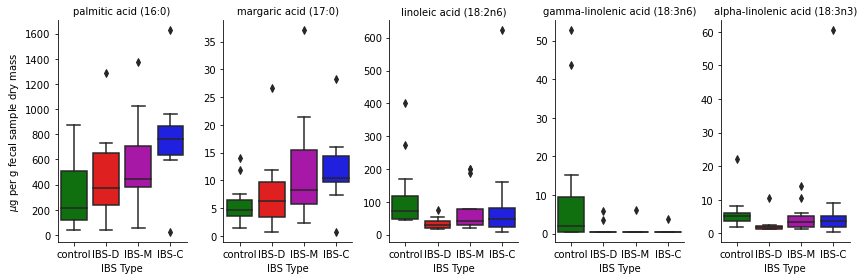

In [201]:
melted_sig = pd.melt(subtypes_sig_df.drop(["pval","-log10 pval"]), id_vars=["IBS", "IBS Type"])
melted_sig.columns = ["IBS","IBS Type","Lipid","Quantity"]
p = sns.catplot(x="IBS Type",
                y="Quantity",
                col="Lipid", sharey=False,
                kind="box",
                data=melted_sig,
                order=["control","IBS-D","IBS-M","IBS-C"],
                palette=["g","r","m","b"])

for ax in p.axes[0]:
    ax.set_title("".join(ax.get_title().split(" = ")[1:]),  fontsize="medium")
    
p.axes[0][0].set_ylabel(r"$\mu$g per g fecal sample dry mass")

plt.gcf().set_size_inches(12,4)
plt.tight_layout()

plt.savefig("Figures/Subtypes_lipid_boxplots.pdf")

plt.show()

## Post hoc testing

`!pip install scikit_posthocs`

In [214]:
from scikit_posthocs import posthoc_dunn

In [218]:
posthocs_df = subtypes_sig_df.drop("IBS", axis=1).drop(["pval", "-log10 pval"])

In [237]:
for col in posthocs_df.columns[:-1]:
    print(col)
    
    res = posthoc_dunn(posthocs_df,val_col=col,group_col="IBS Type")
    print(res[res<=0.05])
    print("\n")

palmitic acid (16:0)
            IBS-C     IBS-D  IBS-M   control
IBS-C         NaN  0.046378    NaN  0.005954
IBS-D    0.046378       NaN    NaN       NaN
IBS-M         NaN       NaN    NaN       NaN
control  0.005954       NaN    NaN       NaN


margaric acid (17:0)
            IBS-C  IBS-D     IBS-M   control
IBS-C         NaN    NaN       NaN  0.011666
IBS-D         NaN    NaN       NaN       NaN
IBS-M         NaN    NaN       NaN  0.043362
control  0.011666    NaN  0.043362       NaN


linoleic acid (18:2n6)
         IBS-C     IBS-D  IBS-M   control
IBS-C      NaN       NaN    NaN       NaN
IBS-D      NaN       NaN    NaN  0.001954
IBS-M      NaN       NaN    NaN       NaN
control    NaN  0.001954    NaN       NaN


gamma-linolenic acid (18:3n6)
            IBS-C  IBS-D     IBS-M   control
IBS-C         NaN    NaN       NaN  0.017205
IBS-D         NaN    NaN       NaN       NaN
IBS-M         NaN    NaN       NaN  0.009097
control  0.017205    NaN  0.009097       NaN


alpha-linole